# libraries

In [2]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, ttest_rel, wilcoxon, friedmanchisquare
from statsmodels.stats.anova import AnovaRM
from templateflow import api as tflow


done


# set global parameters

In [23]:

### Subjects

hypo_cutoff = '<=65mg/dl'
    
if hypo_cutoff == '<=65mg/dl':  ## Main group, for inclusion criteria please refer to the paper
    hypo_sids = ['02','03','05','08','09','10','11','14','16','17','19','20','23','25','26','31','33','34','36','37','38','40','41']
    euart_sids = ['02','05','08','10','11','14','19','23','25','26','27','28','31','33','36','37','38','40','41']

# Include only those eunat subjects that contain also either hypo or euart since needed for contrasts
eunat_sids = sorted(set(hypo_sids) | set(euart_sids))
sids = eunat_sids 

# Subject IDs of different contrasts
glc_contrast_sids = hypo_sids
ins_contrast_sids = euart_sids
clamp_contrast_sids = sorted(set(hypo_sids) & set(euart_sids))

glc_contrast_subj_ids = [f's0{sid}' for sid in glc_contrast_sids]
ins_contrast_subj_ids = [f's0{sid}' for sid in ins_contrast_sids]
clamp_contrast_subj_ids = [f's0{sid}' for sid in clamp_contrast_sids]

# Other subsets referred to later
hypo_subj_ids = [f's0{sid}' for sid in hypo_sids]
eunat_subj_ids = [f's0{sid}' for sid in eunat_sids]
euart_subj_ids = [f's0{sid}' for sid in euart_sids]

# Final subject IDs, the number of subjects
subj_ids = [f's0{sid}' for sid in sids]
n = len(sids)
suffix = f'hypo{hypo_cutoff}_n{n}' 

print('done')


done


# Statistical testing of blood parameters epinephrine, norepinephrine, cortisol, IGF-1, insulin, c-peptide

In [16]:
# Here, we test for each parameter at each timepoint whether there are differences between conditions
# In this way, we check for potential confounding effects of e.g. stress hormones on our parameters of interest, i.e. imaging and behavioral data



# Constants
CONDITIONS = ['hypo', 'euart', 'eunat']
BLOOD_VALUES = ['epi', 'norepi', 'cort', 'ins', 'cpeptide', 'igf1'] #epinephrine, norepinephrine, cortisol, insulin, c-peptide, IGF-1

# Load and preprocess data
df = pd.read_csv("../Data/bloodvalues.csv")
df = df[df['subject'].isin(clamp_contrast_subj_ids)] #include only subjects that we have all 3 sessions of 
columns_to_test = [col for col in df.columns if any(x in col for x in ['_b', '_24', '_MR', '_96'])]
df = df[['condition', 'subject'] + columns_to_test]

# Convert numeric columns and handle missing values
numeric_columns = [col for col in df.columns if col not in ['subject', 'condition']]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

for col in numeric_columns:
    for condition in CONDITIONS:
        median_val = df.loc[df['condition'] == condition, col].median() 
        df.loc[(df['condition'] == condition) & (df[col].isna()), col] = median_val #fill missing values (nans) with median value of respective condition and parameter

# Perform statistical tests
for column in numeric_columns:
    print(f"\nAnalyzing column: {column}")

    # STEP 1: Test for normality
    stat, p_shapiro = shapiro(df[column].dropna())
    print(f"Shapiro-Wilk test p-value: {p_shapiro:.4f}")

    
    # STEP 2: Statistical testing of all three conditions
    if p_shapiro > 0.05: 
        print("Data is normally distributed. Performing Repeated Measures ANOVA.")

        # Prepare data for ANOVA
        data_anova = df.pivot_table(index='subject', columns='condition', values=column).reset_index()
        data_melted = data_anova.melt(id_vars=['subject'], var_name='condition', value_name=column)

        # Perform ANOVA
        anova = AnovaRM(data_melted, depvar=column, subject='subject', within=['condition'])
        anova_results = anova.fit()
        p_anova = anova_results.anova_table['Pr > F'][0]
        print(f"ANOVA p-value: {p_anova:.4f}")

        # STEP 3: post-hoc t-tests of glucose contrast (hypo vs. euart) and insulin contrast (eunat vs. euart)
        for cond1, cond2 in [('hypo', 'euart'), ('eunat', 'euart')]:
            data1 = data_melted[data_melted['condition'] == cond1][column].dropna()
            data2 = data_melted[data_melted['condition'] == cond2][column].dropna()
            t_stat, p_ttest = ttest_rel(data1, data2)
            print(f"Post-hoc t-test ({cond1} vs {cond2}): t = {t_stat:.4f}, p = {p_ttest:.4f}")
    else:
        print("Data is not normally distributed. Performing Friedman’s test.")

        # # STEP 2: Statistical testing of all three conditions in case of non-normality: Prepare data for Friedman's test
        data_friedman = [df.loc[df['condition'] == cond, column].dropna() for cond in CONDITIONS]
        stat_friedman, p_friedman = friedmanchisquare(*data_friedman)
        print(f"Friedman’s test p-value: {p_friedman:.4f}")

        # STEP 3: Wilcoxon post-hoc tests of glucose contrast (hypo vs. euart) and insulin contrast (eunat vs. euart)
        for cond1, cond2 in [('hypo', 'euart'), ('eunat', 'euart')]:
            data1 = df.loc[df['condition'] == cond1, column].dropna()
            data2 = df.loc[df['condition'] == cond2, column].dropna()
            stat_wilcoxon, p_wilcoxon = wilcoxon(data1, data2)
            print(f"Post-hoc Wilcoxon test ({cond1} vs {cond2}): W = {stat_wilcoxon:.4f}, p = {p_wilcoxon:.4f}")



Analyzing column: epi_b
Shapiro-Wilk test p-value: 0.0000
Data is not normally distributed. Performing Friedman’s test.
Friedman’s test p-value: 0.3274
Post-hoc Wilcoxon test (hypo vs euart): W = 34.0000, p = 0.2455
Post-hoc Wilcoxon test (eunat vs euart): W = 41.0000, p = 0.2804

Analyzing column: epi_24
Shapiro-Wilk test p-value: 0.0000
Data is not normally distributed. Performing Friedman’s test.
Friedman’s test p-value: 0.8916
Post-hoc Wilcoxon test (hypo vs euart): W = 48.0000, p = 0.4955
Post-hoc Wilcoxon test (eunat vs euart): W = 48.0000, p = 0.3010

Analyzing column: epi_MR
Shapiro-Wilk test p-value: 0.0000
Data is not normally distributed. Performing Friedman’s test.
Friedman’s test p-value: 0.0001
Post-hoc Wilcoxon test (hypo vs euart): W = 3.0000, p = 0.0008
Post-hoc Wilcoxon test (eunat vs euart): W = 46.0000, p = 0.4265

Analyzing column: epi_96
Shapiro-Wilk test p-value: 0.0000
Data is not normally distributed. Performing Friedman’s test.
Friedman’s test p-value: 0.0910

/opt/conda/envs/neuroenergeticslab_py3.8/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/conda/envs/neuroenergeticslab_py3.8/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/conda/envs/neuroenergeticslab_py3.8/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/conda/envs/neuroenergeticslab_py3.8/lib/python3.8/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there a

Shapiro-Wilk test p-value: 0.0127
Data is not normally distributed. Performing Friedman’s test.
Friedman’s test p-value: 0.0007
Post-hoc Wilcoxon test (hypo vs euart): W = 9.0000, p = 0.0023
Post-hoc Wilcoxon test (eunat vs euart): W = 46.5000, p = 0.2659

Analyzing column: cpeptide_96
Shapiro-Wilk test p-value: 0.0006
Data is not normally distributed. Performing Friedman’s test.
Friedman’s test p-value: 0.0001
Post-hoc Wilcoxon test (hypo vs euart): W = 36.0000, p = 0.2998
Post-hoc Wilcoxon test (eunat vs euart): W = 11.5000, p = 0.0008

Analyzing column: igf1_b
Shapiro-Wilk test p-value: 0.0362
Data is not normally distributed. Performing Friedman’s test.
Friedman’s test p-value: 0.9429
Post-hoc Wilcoxon test (hypo vs euart): W = 71.5000, p = 0.8176
Post-hoc Wilcoxon test (eunat vs euart): W = 75.0000, p = 0.9632

Analyzing column: igf1_24
Shapiro-Wilk test p-value: 0.0064
Data is not normally distributed. Performing Friedman’s test.
Friedman’s test p-value: 0.4655
Post-hoc Wilcoxon 

# Statiscal testing of glucose levels during behavioral testing

In [35]:
#Here, we test whether there are differences in glucose (glc) levels between conditions after the MR scan, i.e. during cognitive testing
#Specifically, we are interested in testing the glucose contrast (hypo/restored eu vs. euart/maintained eu)


# Load the data
df = pd.read_csv("../Data/bloodvalues.csv")

df = df[df['subject'].isin(subj_ids)] # Filter the DataFrame for relevant subjects
df_cleaned = df.dropna(subset=['avg_glc_postMR']) #removing rows with missing values in the average glc post MR column



# Shapiro-Wilk Test for normality
stat, p = shapiro(df_cleaned['avg_glc_postMR'])
print('\nShapiro-Wilk Test:')
print(f'Test Statistic = {stat}, p-value = {p}')
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

    
    
df_cleaned_pivot = df_cleaned.pivot(index='subject', columns='condition', values='avg_glc_postMR')
df_cleaned_pivot = df_cleaned_pivot.dropna()

# Perform Friedmans Test 
statistic, p_value_friedman = friedmanchisquare(*[df_cleaned_pivot[condition] for condition in df_cleaned_pivot.columns])

print('\nFriedman Test Results:')
print(f'Test statistic = {statistic}, p-value = {p_value_friedman}')
if p_value_friedman < alpha:
    print('Reject null hypothesis: Significant differences found between conditions.')
else:
    print('Fail to reject null hypothesis: No significant differences between conditions.')

# Perform post-hoc Wilcoxon Signed-Rank Tests if Friedman is significant
if p_value_friedman < alpha:
    conditions = ['hypo', 'euart', 'eunat']
    
    # Perform pairwise Wilcoxon Signed-Rank Tests: glucose contrast (hypo vs. euart) and insulin contrast (eunat vs euart)
    for cond1, cond2 in [('hypo', 'euart'), ('eunat', 'euart')]:
        subjects_both_conditions = set(df_cleaned[df_cleaned['condition'] == cond1]['subject']).intersection(
            set(df_cleaned[df_cleaned['condition'] == cond2]['subject']))
        df_posthoc = df_cleaned[df_cleaned['subject'].isin(subjects_both_conditions)]
        df_posthoc = df_posthoc.dropna(subset=['avg_glc_postMR'])

        # Extract data for Wilcoxon Signed-Rank Test
        data1 = df_posthoc[df_posthoc['condition'] == cond1]['avg_glc_postMR']
        data2 = df_posthoc[df_posthoc['condition'] == cond2]['avg_glc_postMR']

        # Perform Wilcoxon Signed-Rank test if the data has the same number of subjects
        if len(data1) == len(data2):
            stat, p_value = wilcoxon(data1, data2)
            print(f"\nPost-hoc Wilcoxon Signed-Rank test ({cond1} vs {cond2}):")
            print(f'Test statistic = {stat}, p-value = {p_value}')
            if p_value < alpha:
                print(f"Reject null hypothesis: Significant difference between {cond1} and {cond2}")
            else:
                print(f"Fail to reject null hypothesis: No significant difference between {cond1} and {cond2}")
        else:
            print(f"Skipping Wilcoxon test for {cond1} vs {cond2} due to unequal number of subjects.")



Shapiro-Wilk Test:
Test Statistic = 0.8952503800392151, p-value = 5.3236923122312874e-05
Sample does not look Gaussian (reject H0)

Friedman Test Results:
Test statistic = 19.30000000000001, p-value = 6.442556703435508e-05
Reject null hypothesis: Significant differences found between conditions.

Post-hoc Wilcoxon Signed-Rank test (hypo vs euart):
Test statistic = 66.0, p-value = 0.15364646911621094
Fail to reject null hypothesis: No significant difference between hypo and euart

Post-hoc Wilcoxon Signed-Rank test (eunat vs euart):
Test statistic = 5.0, p-value = 1.9073486328125e-05
Reject null hypothesis: Significant difference between eunat and euart


# Plots epinephrine, norepinephrine, cortisol, IGF-1, insulin, c-peptide

In [ ]:
#Here, we test whether glucose levels between hypo/restored eu and euart/maintained eu differ during behavioral testing
#We want to ensure that glucose levels do not differ 


# Constants
BLOOD_VALUES = ['epi', 'norepi', 'cort', 'ins', 'cpeptide', 'igf1']
TIMEPOINTS = ['b', '24', '48', '72', '96'] #b denotes baseline measures before clamp onset; the rest is time in minutes since clamp start
CUSTOM_PALETTE = {'hypo': '#e06666', 'euart': '#999794', 'eunat': '#6fa8dc'}
CONDITION_LABELS = ['hypo', 'eunat', 'euart']

# Blood value-specific details
BLOOD_LABELS = {
    'epi': ('Epinephrine in pg/ml', 'Epinephrine', 0, 250),
    'norepi': ('Norepinephrine in pg/ml', 'Norepinephrine', 0, 800),
    'cort': ('Cortisol in µg/dl', 'Cortisol', 0, 30),
    'ins': ('Insulin in µU/mL', 'Insulin', 0, 200),
    'cpeptide': ('C-peptide in ng/ml', 'C-peptide', 0, 5),
    'igf1': ('IGF1 in ng/ml', 'IGF1', 0, 350)
}

# Load and preprocess data
df = pd.read_csv("../Data/bloodvalues.csv")

# Filter data for relevant conditions and subjects
condition_subj_map = {'hypo': hypo_subj_ids, 'euart': euart_subj_ids, 'eunat': eunat_subj_ids}
df = pd.concat([df[(df['condition'] == cond) & (df['subject'].isin(subj_ids))]
                for cond, subj_ids in condition_subj_map.items()])


# Generate plots for each blood value
sns.set_style('darkgrid')
for blood_value in BLOOD_VALUES:
    # Prepare data
    columns = [f'{blood_value}_{timepoint}' for timepoint in TIMEPOINTS] + ['condition']
    blood_df = df[columns]
    
    melted = blood_df.melt(id_vars='condition', var_name='time', value_name=blood_value)
    if blood_value in ['ins', 'cpeptide']:
        melted[blood_value] = pd.to_numeric(melted[blood_value], errors='coerce')

    y_label, title, ymin, ymax = BLOOD_LABELS[blood_value]
    fig, ax = plt.subplots(figsize=(12, 7))

    # Pointplot with stripplot overlay
    sns.pointplot(
        data=melted, x='time', y=blood_value, hue='condition',
        hue_order=CONDITION_LABELS, join=True, palette=CUSTOM_PALETTE, scale=0.5, ax=ax
    )
    sns.stripplot(
        data=melted, x='time', y=blood_value, hue='condition',
        dodge=True, jitter=0.3, palette=CUSTOM_PALETTE, size=3, ax=ax
    )

    #x-axis labels
    plt.xticks(
        ticks=range(len(TIMEPOINTS)),
        labels=['0', '24', '48 (MR)', '72 (MR)', '96 (beh. testing)'],
        fontsize=12
    )

    #legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:3], labels[:3], fontsize=13, title="Condition")

    # Set title, labels and limits
    plt.title(f'{title} across clamping', fontsize=19)
    plt.xlabel('Time since clamp onset in minutes', fontsize=16)
    ax.tick_params(axis='y', labelsize=13)
    ax.tick_params(axis='x', labelsize=13)
    plt.ylabel(y_label, fontsize=16)
    plt.ylim(ymin, ymax)


    plt.show()


# Plot plasma glucose levels 

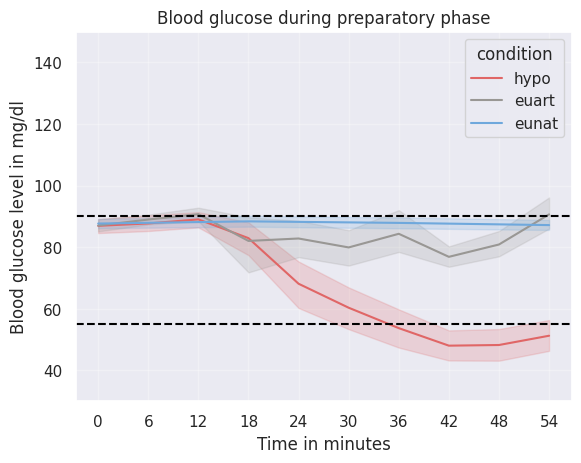

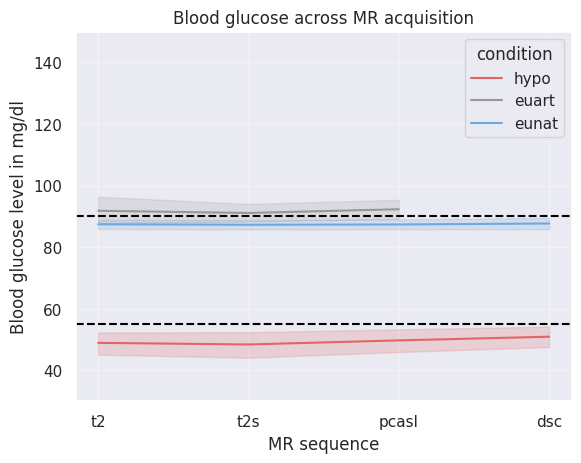

In [27]:
#Here, we plot blood glucose levels across participants during (1) the preparatory phase and (2) during MR scanning
#The second plot can be seen as a continuation of the first one

CUSTOM_PALETTE = {'hypo': '#e06666', 'euart': '#999794', 'eunat': '#6fa8dc'} #define custom color palette 

# Prepare the data
df = pd.read_csv("../Data/glc_clamp_prep_MR.csv")

# Create hypo and euart dfs
hypo_df = df[df['condition'] == 'hypo']
hypo_df = hypo_df[hypo_df['subject'].isin(glc_contrast_subj_ids)]

euart_df = df[df['condition'] == 'euart']
euart_df = euart_df[euart_df['subject'].isin(ins_contrast_subj_ids)]

# Concatenate dfs
filtered_df = pd.concat([hypo_df, euart_df, df[df['condition'] == 'eunat']])
filtered_df.reset_index(drop=True, inplace=True)
glc = filtered_df.drop(filtered_df.columns[0], axis=1)

# Melt dataframe
glc_melted = glc.melt(id_vars='condition', var_name='Time', value_name='Glucose')

# Define the timepoints for the first plot (preparatory phase; before MR scanning)
timepoints_1 = ['0', '6', '12', '18', '24', '30', '36', '42', '48', '54']  # time in minutes
glc_melted = glc_melted.replace(f'glc_b', '0')
for timepoint in timepoints_1:
    glc_melted = glc_melted.replace(f'glc_{timepoint}', timepoint)

# Define the MR sequences for the second plot (during MR scanning)
sequences = ['TRUST', 't2', 't2s', 'pcasl', 'bold', 'dsc']
for sequence in sequences:
    glc_melted = glc_melted.replace(f'glc_{sequence}', sequence)

# Filter for preparatory data (timepoints 0-54)
glc_clamp = glc_melted[glc_melted['Time'].isin(timepoints_1)]

# Filter for blood glc during MR scanning 
glc_MR = glc_melted[glc_melted['Time'].isin(['t2', 't2s', 'pcasl', 'dsc'])]




## PLOTTING

# Plot blood glc during prepatory phase
sns.set(style='darkgrid')
ax = sns.lineplot(data=glc_clamp, x='Time', y='Glucose', hue='condition', palette=CUSTOM_PALETTE, legend='brief')
ax.set(ylabel='Blood glucose level in mg/dl', xlabel='Time in minutes')
ax.set_ylim(30, 150)
plt.title('Blood glucose during preparatory phase')
plt.axhline(y=55, color='black', linestyle='--')
plt.axhline(y=90, color='black', linestyle='--')

plt.show()

# Plot blood glc during MR scanning 
sns.set(style='darkgrid')
ax = sns.lineplot(data=glc_MR, x='Time', y='Glucose', hue='condition', palette=CUSTOM_PALETTE, legend='brief')
ax.set(ylabel='Blood glucose level in mg/dl', xlabel='MR sequence')
ax.set_ylim(30, 150)
plt.title('Blood glucose across MR acquisition')
plt.axhline(y=55, color='black', linestyle='--')
plt.axhline(y=90, color='black', linestyle='--')

plt.show()

